# Regularized Linear Regression and Bias vs. Variance

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
%matplotlib inline

## 1 Regularized linear regression

In [2]:
df = sio.loadmat('ex5data1.mat')

In [3]:
X = df['X']
y = df['y']
X_test = df['Xtest']
y_test = df['ytest']
X_val = df['Xval']
y_val = df['yval']

### 1.1 Data visualization

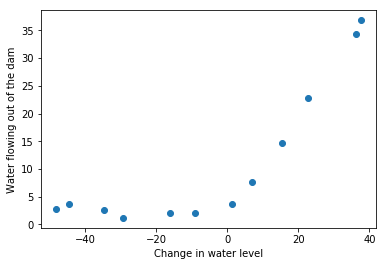

In [4]:
plt.plot(X, y, lw=0, marker='o')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of the dam')
plt.show()

### 1.2 Regularized lienar regression cost function

$J(\theta) = \frac{1}{2m} \sum^{m}_{i=1} \left ( h_{\theta} (x^{(i)}) - y^{(i)} \right )^{2} + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$

$h_{\theta}(x) = \theta^{T}x = \theta_{0} + \theta_{1}x_{1} $

Fully vectorized form. Note that last term does not include $\theta_{0}$

$J(\theta) = \frac{1}{2m} ( X\theta - y )^{T} ( X\theta - y ) + \frac{\lambda}{2m}\theta^{T}\theta$

In [5]:
def linearRegCostFunction(theta, X, y, l):
    m = len(y)
    h = np.matmul(X, theta).reshape(-1,1)
    hmy = h - y
    J = np.matmul((hmy).transpose(), hmy)
    J += l*np.matmul(theta[1:].transpose(), theta[1:])
    J /= 2.0*m
    return J.ravel()[0]

In [6]:
# Should be about 303.993192
theta = np.array([1., 1.]).reshape(-1,1)
linearRegCostFunction(theta, np.hstack((np.ones((X.shape[0],1)), X)), y, 1)

303.9931922202643

### 1.3 Regularized linear regression gradient


$\frac{\delta J(\theta)}{\delta \theta_{j}} = \frac{1}{m} \sum^{m}_{i=1} \left ( h_{\theta} (x^{(i)} - y^{(i)} \right )x_{j}^{(i)} + \frac{\lambda}{m}\theta_{j}$

Vectorized version

$\frac{\delta J(\theta)}{\delta \theta_{j}} = \frac{1}{m} X^{T} ( X\theta - y ) + \frac{\lambda}{m}\theta_{j}$

In [7]:
def linearRegGradFunction(theta, X, y, l):
    m = len(y)
    h = np.matmul(X, theta).reshape(-1,1)
    grad = np.matmul(np.transpose(X), h - y)
    grad[1:] += l*theta[1:].reshape(-1,1)
    grad /= m
    return grad.ravel()

In [8]:
# Expect -15.30 and 598.250
theta = np.array([1., 1.]).reshape(-1,1)
linearRegGradFunction(theta, np.hstack((np.ones((X.shape[0],1)), X)), y, 1)

array([-15.30301567, 598.25074417])

### 1.4 Fitting lienar regression

In [9]:
from scipy.optimize import minimize

In [10]:
theta = np.zeros((X.shape[1]+1,1))
l = 0.
minimize_result = minimize(linearRegCostFunction, theta, method="CG", 
                           jac=linearRegGradFunction, args=(np.hstack((np.ones((X.shape[0],1)), X)), y, l), 
                           options={"maxiter": 1000})

In [11]:
minimize_result.x

array([13.08790351,  0.36777923])

In [12]:
def predict(X, theta):
    return np.matmul(X, theta)

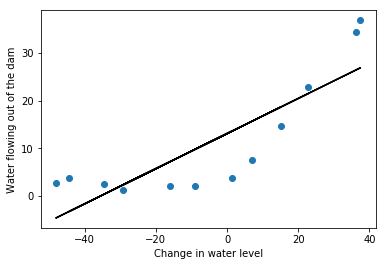

In [13]:
plt.plot(X, y, lw=0, marker='o')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of the dam')
plt.plot(X, predict(np.hstack((np.ones((X.shape[0],1)), X)), minimize_result.x), color='black')
plt.show()

## 2 Bias-variance

### 2.1 Learning curves

Training error for the data set is identical to the cost function without the regularization them:

$J_{train}(\theta) = \frac{1}{2m} \left [ \sum^{m}_{i=1} ( h_{\theta}(x^{(i)}) - y^{(i)})^{2} \right ] $

In [14]:
def learningCurve(X, y, X_val, y_val, l):
    
    m = X.shape[0]
    error_train = np.zeros(m+1)
    error_val = np.zeros(m+1)
    
    for i in range(1,m+1):
        
        X_train = X[:i,:]
        y_train = y[:i]
        theta = np.zeros(X.shape[1])
        theta = minimize(linearRegCostFunction, theta, method="CG", 
                           jac=linearRegGradFunction, args=(X_train, y_train, l), 
                           options={"maxiter": 1000})

        error_train[i] = linearRegCostFunction(theta.x, X_train, y_train, 0.)
        error_val[i] = linearRegCostFunction(theta.x, X_val, y_val, 0.)
    
    return error_train, error_val

In [15]:
error_train, error_val = learningCurve(
    np.hstack((np.ones((X.shape[0],1)), X)), y, 
    np.hstack((np.ones((X_val.shape[0],1)), X_val)), y_val,
    0)

In [16]:
def plotLearningCurve(error_train, error_val):
    plt.plot(np.arange(1,len(error_train)), error_train[1:], label="Train error")
    plt.plot(np.arange(1,len(error_val)), error_val[1:], label="Validation error")
    plt.ylim([0,150])
    plt.legend()
    plt.xlabel("Number of training examples")
    plt.ylabel("Error")
    plt.title("Learning curve for linear regression")
    plt.show()

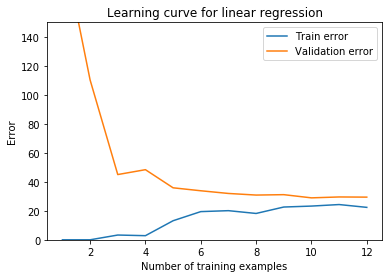

In [17]:
plotLearningCurve(error_train, error_val)

## 3 Polynomial Regression

In [18]:
def polyFeatures(X, p):
    X_poly = np.zeros((X.shape[0], p))
    for i in range(p):
        X_poly[:,i] = (X**(i+1)).ravel()
    return X_poly

In [19]:
p = 8
X_poly = polyFeatures(X, p)

# Feature normalization
mu = np.mean(X_poly, axis=0)
sigma = np.std(X_poly, axis=0)
X_poly = (X_poly - mu) / sigma
X_poly = np.hstack((np.ones((X_poly.shape[0],1)), X_poly))

X_poly_test = polyFeatures(X_test, p)
X_poly_test = (X_poly_test - mu) / sigma
X_poly_test = np.hstack((np.ones((X_poly_test.shape[0],1)), X_poly_test))

X_poly_val = polyFeatures(X_val, p)
X_poly_val = (X_poly_val - mu) / sigma
X_poly_val = np.hstack((np.ones((X_poly_val.shape[0],1)), X_poly_val))

In [20]:
X_poly.shape

(12, 9)

In [21]:
X.shape

(12, 1)

### 3.1 Learning polynomial regression
#### 3.1.1 No regularization

In [22]:
theta = np.zeros((X_poly.shape[1],1))
l = 0.
theta = minimize(linearRegCostFunction, theta, method="CG", 
                 jac=linearRegGradFunction, args=(X_poly, y, l), 
                 options={"maxiter": 1000})

In [23]:
def plotFit(X, y, theta):
    plt.plot(X, y, lw=0, marker='o')
    plt.xlabel('Change in water level')
    plt.ylabel('Water flowing out of the dam')

    x = np.arange(min(X)-35.,max(X)+15,0.05)
    X_poly = polyFeatures(x, p)
    X_poly = (X_poly - mu) / sigma
    X_poly = np.hstack((np.ones((X_poly.shape[0],1)), X_poly))
    plt.plot(x, np.matmul(X_poly, theta), color='black')
    plt.show()

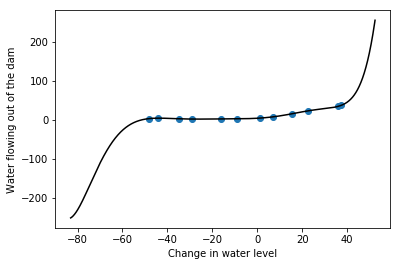

In [24]:
plotFit(X, y, theta.x)

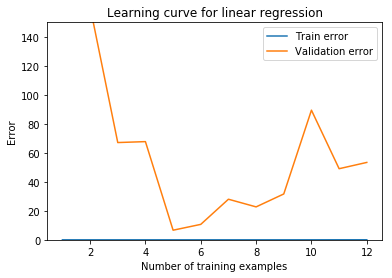

In [25]:
error_train, error_val = learningCurve(X_poly, y, X_poly_val, y_val, 0)
plotLearningCurve(error_train, error_val)

#### 3.1.2 Lambda = 1.0

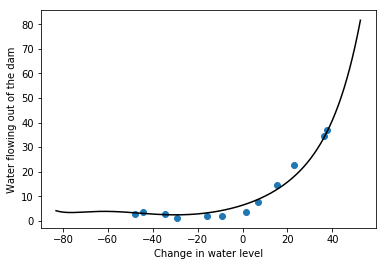

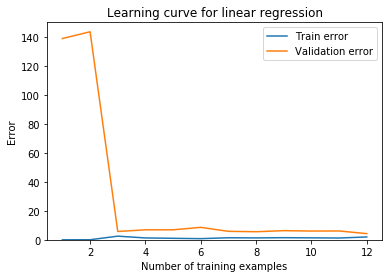

In [26]:
theta = np.zeros((X_poly.shape[1],1))
l = 1.
theta = minimize(linearRegCostFunction, theta, method="CG", 
                 jac=linearRegGradFunction, args=(X_poly, y, l), 
                 options={"maxiter": 1000})
plotFit(X, y, theta.x)
error_train, error_val = learningCurve(X_poly, y, X_poly_val, y_val, l)
plotLearningCurve(error_train, error_val)

### 3.1.3 Lambda = 100.0

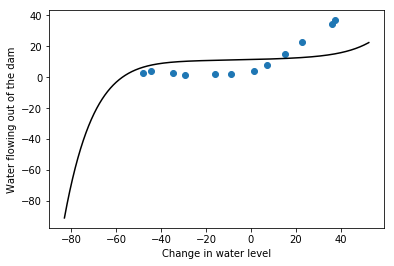

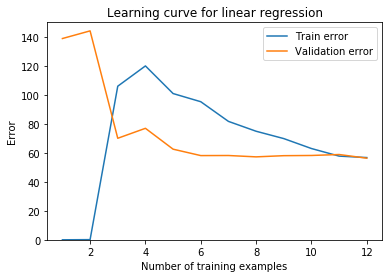

In [27]:
theta = np.zeros((X_poly.shape[1],1))
l = 100.
theta = minimize(linearRegCostFunction, theta, method="CG", 
                 jac=linearRegGradFunction, args=(X_poly, y, l), 
                 options={"maxiter": 1000})
plotFit(X, y, theta.x)
error_train, error_val = learningCurve(X_poly, y, X_poly_val, y_val, l)
plotLearningCurve(error_train, error_val)

## 3.3 Grid search

In [28]:
lambdas = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]
error_train = np.zeros((len(lambdas),1))
error_val = np.zeros((len(lambdas),1))
for i, l in enumerate(lambdas):
    theta = np.zeros((X_poly.shape[1],1))
    theta = minimize(linearRegCostFunction, theta, method="CG", 
                 jac=linearRegGradFunction, args=(X_poly, y, l), 
                 options={"maxiter": 1000})
    error_train[i] = linearRegCostFunction(theta.x, X_poly, y, 0.)
    error_val[i] = linearRegCostFunction(theta.x, X_poly_val, y_val, 0.)

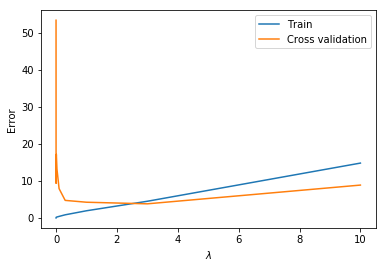

In [29]:
plt.plot(lambdas, error_train, label="Train")
plt.plot(lambdas, error_val, label="Cross validation")
plt.xlabel("$\lambda$")
plt.ylabel("Error")
plt.legend()
plt.show()

Evalulate model on test set

In [30]:
# lambda = 3
error_val[8]

array([3.83217638])

### 3.4 Test set error

In [31]:
theta = np.zeros((X_poly.shape[1],1))
theta = minimize(linearRegCostFunction, theta, method="CG", 
                 jac=linearRegGradFunction, args=(X_poly, y, 3.), 
                 options={"maxiter": 1000})
error_test = linearRegCostFunction(theta.x, X_poly_test, y_test, 0.)

In [32]:
error_test

3.5720266199734914

## 4 Scikit-learn

In [33]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, GridSearchCV, validation_curve

In [34]:
df = sio.loadmat('ex5data1.mat')
X = df['X']
y = df['y']
X_test = df['Xtest']
y_test = df['ytest']
X_val = df['Xval']
y_val = df['yval']

In [35]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

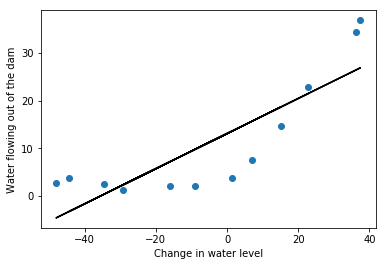

In [36]:
plt.plot(X, y, lw=0, marker='o')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of the dam')
plt.plot(X, lr.predict(X), color='black')
plt.show()

### 4.1 Polynomial features with no regularization

In [37]:
pipe = Pipeline([("poly", PolynomialFeatures(8)),
                 ("ss", StandardScaler()),
                 ("lr", LinearRegression())]).fit(X,y)

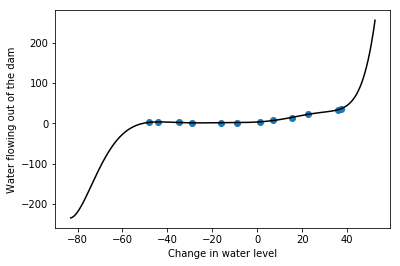

In [38]:
plt.plot(X, y, lw=0, marker='o')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of the dam')
xplt = np.arange(min(X)-35.,max(X)+15,0.05)
plt.plot(xplt, pipe.predict(xplt.reshape(-1,1)), color='black')
plt.show()

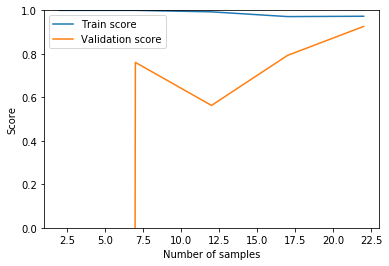

In [39]:
X = df['X']
y = df['y']
X_val = df['Xval']
y_val = df['yval']
X = np.append(X, X_val).reshape(-1,1)
y = np.append(y, y_val).reshape(-1,1)
train_sizes, train_score, val_score = learning_curve(pipe, X, y)
plt.plot(train_sizes, np.mean(train_score, axis=1), label="Train score")
plt.plot(train_sizes, np.mean(val_score, axis=1), label="Validation score")
plt.xlabel("Number of samples")
plt.ylabel("Score")
plt.ylim([0,1])
plt.legend()
plt.show()

### 4.2 Polynomial features with $\lambda = 5$

In [40]:
pipe = Pipeline([("poly", PolynomialFeatures(8)),
                 ("ss", StandardScaler()),
                 ("ridge", Ridge(5))]).fit(X,y)

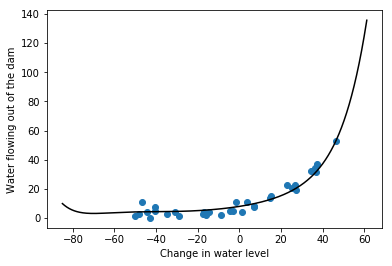

In [41]:
plt.plot(X, y, lw=0, marker='o')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of the dam')
xplt = np.arange(min(X)-35.,max(X)+15,0.05)
plt.plot(xplt, pipe.predict(xplt.reshape(-1,1)), color='black')
plt.show()

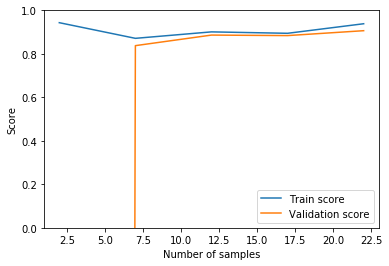

In [42]:
X = df['X']
y = df['y']
X_val = df['Xval']
y_val = df['yval']
X = np.append(X, X_val).reshape(-1,1)
y = np.append(y, y_val).reshape(-1,1)
train_sizes, train_score, val_score = learning_curve(pipe, X, y)
plt.plot(train_sizes, np.mean(train_score, axis=1), label="Train score")
plt.plot(train_sizes, np.mean(val_score, axis=1), label="Validation score")
plt.xlabel("Number of samples")
plt.ylabel("Score")
plt.ylim([0,1])
plt.legend()
plt.show()

### 4.3 Polynomial features with $\lambda = 100$

In [43]:
pipe = Pipeline([("poly", PolynomialFeatures(8)),
                 ("ss", StandardScaler()),
                 ("ridge", Ridge(100.0))]).fit(X,y)

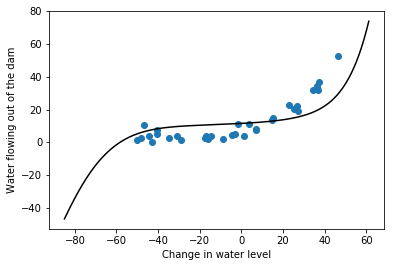

In [44]:
plt.plot(X, y, lw=0, marker='o')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of the dam')
xplt = np.arange(min(X)-35.,max(X)+15,0.05)
plt.plot(xplt, pipe.predict(xplt.reshape(-1,1)), color='black')
plt.show()

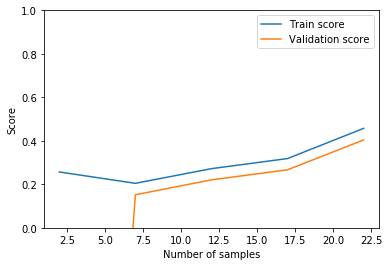

In [45]:
X = df['X']
y = df['y']
X_val = df['Xval']
y_val = df['yval']
X = np.append(X, X_val).reshape(-1,1)
y = np.append(y, y_val).reshape(-1,1)
train_sizes, train_score, val_score = learning_curve(pipe, X, y)
plt.plot(train_sizes, np.mean(train_score, axis=1), label="Train score")
plt.plot(train_sizes, np.mean(val_score, axis=1), label="Validation score")
plt.xlabel("Number of samples")
plt.ylabel("Score")
plt.ylim([0,1])
plt.legend()

In [46]:
X = df['X']
y = df['y']
X_val = df['Xval']
y_val = df['yval']
X = np.append(X, X_val).reshape(-1,1)
y = np.append(y, y_val).reshape(-1,1)
pipe = Pipeline([("poly", PolynomialFeatures(8)),
                 ("ss", StandardScaler()),
                 ("ridge", Ridge())])
alphas = {"ridge__alpha": [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.] }

In [47]:
grid = GridSearchCV(pipe, alphas).fit(X, y)

In [48]:
grid.best_params_

{'ridge__alpha': 0.3}

In [49]:
print("Train score = {0:.3f}".format(grid.score(X, y)))
print("Test score = {0:.3f}".format(grid.score(X_test, y_test)))

Train score = 0.966
Test score = 0.951


### 4.4 Validation curves

In [50]:
alphas = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]
train_scores, test_scores = validation_curve(pipe, X, y, param_name="ridge__alpha", param_range=alphas)

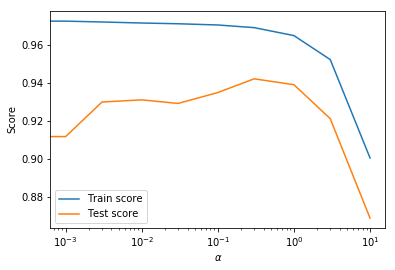

In [51]:
plt.plot(alphas, np.mean(train_scores, axis=1), label="Train score")
plt.plot(alphas, np.mean(test_scores, axis=1), label="Test score")
plt.xlabel("$\\alpha$")
plt.ylabel("Score")
plt.xscale("log")
plt.legend()
plt.show()

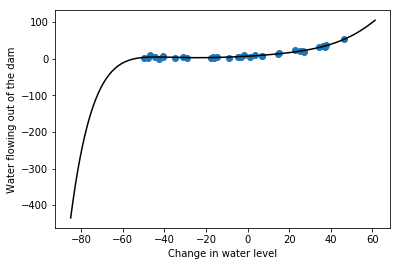

In [52]:
plt.plot(X, y, lw=0, marker='o')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of the dam')
xplt = np.arange(min(X)-35.,max(X)+15,0.05)
plt.plot(xplt, grid.predict(xplt.reshape(-1,1)), color='black')
plt.show()